In [2]:
%matplotlib inline
import swat as sw
import sys
sys.path.append(r'\\sashq\root\dept\cas\weshiz\github_vb025\python-dlpy')

#import dlpy
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *
# from dlpy.network import *

import time
from matplotlib import pylab as plt
from matplotlib import image as mpim

In [3]:
s = sw.CAS('DLGRD009.unx.sas.com', 13300, nworkers=1) 

In [4]:
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00549s, user: 0.00358s, sys: 0.000366s, mem: 0.212mb

In [5]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/cas/DeepLearn/weshiz',
                  subdirectories=False)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dnfs,PATH,,/cas/DeepLearn/weshiz/,,0.0,1.0,0.0,0.0,0.0,0.0


### Loading training data
The data is cropped from original training images. The dataset contains 30 pics. The image size is 128 * 128. 

In [6]:
s.table.loadTable(caslib = 'dnfs', path = 'membrane_train_imglabel_512.sashdat',
                  casout = dict(name = 'data', replace = True))

NOTE: Cloud Analytic Services made the file membrane_train_imglabel_512.sashdat available as table DATA in caslib CASUSER(weshiz).


[caslib]

 'CASUSER(weshiz)'

[tableName]

 'DATA'

[casTable]

 CASTable('DATA', caslib='CASUSER(weshiz)')

+ Elapsed: 0.101s, user: 0.00183s, sys: 0.000301s, mem: 0.669mb

In [7]:
s.image.summarizeimages('data')

NOTE: Table DATA contains compressed images.
NOTE: 30 out of 30 images were scanned and results were saved to the summary table.


,Column,jpg,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,30.0,512.0,512.0,512.0,512.0,512.0,512.0,126.163219,0.0,255.0,126.163219,0.0,255.0,126.163219,0.0,255.0


In [8]:
# data2 = s.CASTable('data', where = '_filename_0 not in ("1.tif", "2.tif")')

### Build UNet
The network is proposed by https://github.com/zhixuhao/unet. In the script, the author uses 256 by 256 images. Here we use 512 by 512 images to do the experiment. Except the size of the images, I replace upsampleing layer with transpose convolution layer.

In [12]:
init=None
factor = 1
inputs = Input(1, 512/factor, 512/factor, scale = 1.0 / 255, name='InputLayer_1')
conv1 = Conv2d(64, 3, act = 'relu', init=init)(inputs)
conv1 = Conv2d(64, 3, act = 'relu', init=init)(conv1)
pool1 = Pooling(2)(conv1)
# 256
conv2 = Conv2d(128, 3, act = 'relu', init=init)(pool1)
conv2 = Conv2d(128, 3, act = 'relu', init=init)(conv2)
pool2 = Pooling(2)(conv2)
# 128
conv3 = Conv2d(256, 3, act = 'relu', init=init)(pool2)
conv3 = Conv2d(256, 3, act = 'relu', init=init)(conv3)
pool3 = Pooling(2)(conv3)
# 64
conv4 = Conv2d(512, 3, act = 'relu', init=init)(pool3)
conv4 = Conv2d(512, 3, act = 'relu', init=init)(conv4)
pool4 = Pooling(2)(conv4)
# 32
conv5 = Conv2d(1024, 3, act = 'relu', init=init)(pool4)
conv5 = Conv2d(1024, 3, act = 'relu', init=init)(conv5)

tconv6 = Transconvo(512, 3, stride = 2, act='relu', padding = 1, output_size = conv4._op.output_size, init=init)(conv5) # 64
merge6 = Concat()([conv4, tconv6])
conv6 = Conv2d(512, 3, act = 'relu', init=init)(merge6)
conv6 = Conv2d(512, 3, act = 'relu', init=init)(conv6)

tconv7 = Transconvo(256, 3, stride = 2, act='relu', padding = 1, output_size = conv3._op.output_size, init=init)(conv6)  # 128
merge7 = Concat()([conv3, tconv7])
conv7 = Conv2d(256, 3, act = 'relu', init=init)(merge7)
conv7 = Conv2d(256, 3, act = 'relu', init=init)(conv7)

tconv8 = Transconvo(128, stride = 2, act='relu', padding = 1, output_size = conv2._op.output_size, init=init)(conv7)  # 256
merge8 = Concat()([conv2, tconv8])
conv8 = Conv2d(128, 3, act = 'relu', init=init)(merge8)
conv8 = Conv2d(128, 3, act = 'relu', init=init)(conv8)

tconv9 = Transconvo(64, stride = 2, act='relu', padding = 1, output_size = conv1._op.output_size, init=init)(conv8)  # 512
merge9 = Concat()([conv1, tconv9])
conv9 = Conv2d(64, 3, act = 'relu', init=init)(merge9)
conv9 = Conv2d(64, 3, act = 'relu', init=init)(conv9)

conv9 = Conv2d(2, 3, act = 'relu', init=init)(conv9)

seg1 = Segmentation(name='Segmentation_1')(conv9)
model = Model(s, inputs = inputs, outputs = seg1)
model.compile()
model.print_summary()

NOTE: Model compiled successfully.


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,InputLayer_1,input,,,None,"(512, 512, 1)","(0, 0)"
1,1,Conv2d_21,convo,"(3, 3)",1,Relu,"(512, 512, 64)","(576, 64)"
2,2,Conv2d_22,convo,"(3, 3)",1,Relu,"(512, 512, 64)","(36864, 64)"
3,3,Pooling_9,pool,"(2, 2)",2,Max,"(256, 256, 64)","(0, 0)"
4,4,Conv2d_23,convo,"(3, 3)",1,Relu,"(256, 256, 128)","(73728, 128)"
5,5,Conv2d_24,convo,"(3, 3)",1,Relu,"(256, 256, 128)","(147456, 128)"
6,6,Pooling_10,pool,"(2, 2)",2,Max,"(128, 128, 128)","(0, 0)"
7,7,Conv2d_25,convo,"(3, 3)",1,Relu,"(128, 128, 256)","(294912, 256)"
8,8,Conv2d_26,convo,"(3, 3)",1,Relu,"(128, 128, 256)","(589824, 256)"
9,9,Pooling_11,pool,"(2, 2)",2,Max,"(64, 64, 256)","(0, 0)"


### Plot UNet

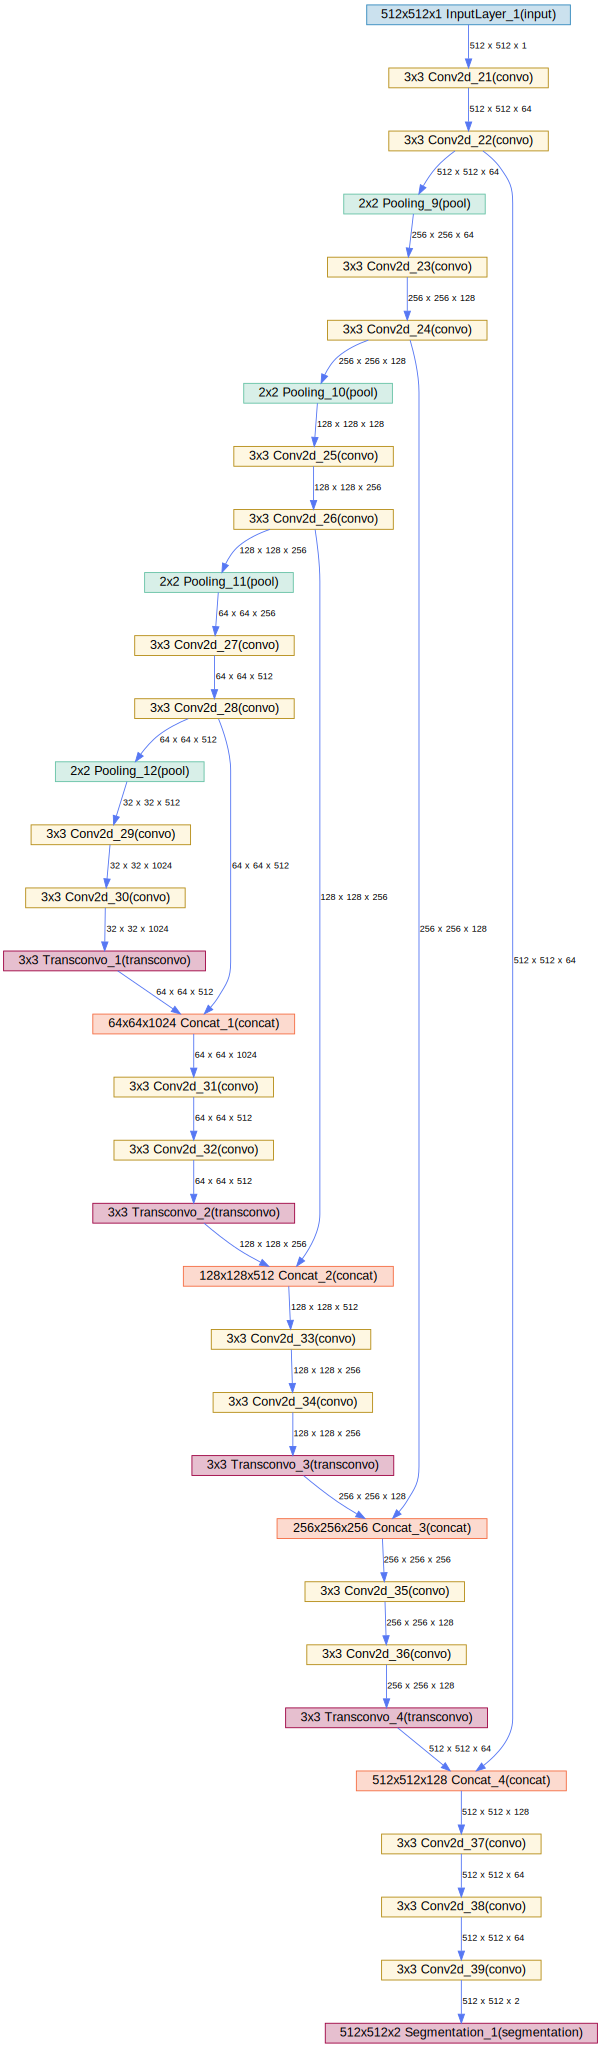

In [13]:
model.plot_network()

In [14]:
targets = s.CASTable('data').columns[4:];targets

Index(['labels'], dtype='object')

### Train the model
Train on the 128*128 images from scratch.
- Adam Learning rate = 0.0001 
- regL2 = 0.0001
- miniBatchSize = 1 nthreads = 4
- 50 epochs

In [15]:
s.columninfo('data')

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_filename_0,1,varchar,6,6,0,0
1,_image_,2,varbinary,223576,223576,0,0
2,_label_,3,varchar,0,1,0,0
3,_id_,4,int64,8,12,0,0
4,labels,5,varbinary,27389,27389,0,0


In [16]:
s.dlTrain(model = model.model_name, table = 'data', nthreads=2, 
          modelWeights = dict(name = 'seg_weights', replace = True),
          dataspecs=[dict(type='image', layer='InputLayer_1', data=['_image_']),
                     dict(type='image', layer='Segmentation_1', data='labels')],
          gpu=Gpu(devices=[0, 1]),
          optimizer = dict(miniBatchSize = 1, regL2 = 0.0001,
                           algorithm = dict(method = "adam", clipgradmax = 100, clipgradmin = -100,
                                            learningrate = 0.0001,
                                            lrPolicy = 'step', gamma = 0.1,
                                            stepSize = 30),
                           maxEpochs = 50, logLevel = 3, seed = 13309
                           )
          )

NOTE: Using dlgrd009.unx.sas.com: 2 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34513282.
NOTE:  The approximate memory cost is 17626.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      14.60 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 2.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        1.834e+05     0.7075     0.6846     4.42
NOTE:      1     2   0.0001        1.797e+05      0.261     0.6831     0.13
NOTE:      2     2   0.0001        1.768e+05     0.2109     0.6817     0.13
NOTE:      3     2   0.0001        1.746e+05     0.2158     0.6802     0.13
NOTE:      

NOTE:     14     2   0.0001        1.205e+05     0.2227     0.5902     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  6        0.0001       8.793e+04      0.154     1.90
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        8.927e+04     0.1626     0.5898     0.13
NOTE:      1     2   0.0001        8.369e+04     0.1436     0.5895     0.13
NOTE:      2     2   0.0001        1.073e+05     0.1729     0.5892     0.14
NOTE:      3     2   0.0001        9.281e+04     0.1583     0.5888     0.13
NOTE:      4     2   0.0001        8.295e+04     0.1415     0.5885     0.13
NOTE:      5     2   0.0001        8.203e+04      0.144     0.5882     0.13
NOTE:      6     2   0.0001         6.96e+04     0.1183      0.588     0.13
NOTE:      7     2   0.0001        8.044e+04     0.1337     0.5877     0.13
NOTE:      8     2   0.0001        9.647e+04     0.1639     0.5874     0.13
NOTE:      9     2   0.0001      

NOTE:     11     2   0.0001        9.359e+04     0.1692      0.575     0.13
NOTE:     12     2   0.0001        8.687e+04     0.1525     0.5749     0.13
NOTE:     13     2   0.0001        8.462e+04     0.1402     0.5748     0.13
NOTE:     14     2   0.0001        7.241e+04     0.1218     0.5748     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  13       0.0001       8.439e+04     0.1474     1.91
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        7.747e+04     0.1338     0.5747     0.13
NOTE:      1     2   0.0001        7.697e+04     0.1335     0.5747     0.13
NOTE:      2     2   0.0001        7.624e+04     0.1295     0.5746     0.13
NOTE:      3     2   0.0001        7.744e+04     0.1309     0.5745     0.13
NOTE:      4     2   0.0001        7.857e+04     0.1307     0.5745     0.14
NOTE:      5     2   0.0001        7.644e+04     0.1319     0.5744     0.13
NOTE:      6     2   0.0001      

NOTE:      4     2   0.0001        9.092e+04     0.1547     0.5731     0.13
NOTE:      5     2   0.0001        8.301e+04      0.145     0.5731     0.13
NOTE:      6     2   0.0001        6.495e+04     0.1076     0.5731     0.13
NOTE:      7     2   0.0001        7.263e+04     0.1222     0.5731     0.13
NOTE:      8     2   0.0001        8.118e+04     0.1414     0.5731     0.13
NOTE:      9     2   0.0001        8.194e+04     0.1415     0.5731     0.13
NOTE:     10     2   0.0001        8.302e+04     0.1399     0.5731     0.13
NOTE:     11     2   0.0001        8.357e+04     0.1445     0.5731     0.13
NOTE:     12     2   0.0001        7.792e+04     0.1307     0.5731     0.13
NOTE:     13     2   0.0001        8.278e+04     0.1391      0.573     0.13
NOTE:     14     2   0.0001        7.526e+04     0.1302      0.573     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  20       0.0001       8.091e+04     0.1388     1.92
NOTE:  Batch nUsed Learning Rate        Loss 

NOTE:      5     2   0.0001        6.768e+04     0.1137     0.5739     0.13
NOTE:      6     2   0.0001        6.335e+04     0.1104     0.5739     0.13
NOTE:      7     2   0.0001        7.301e+04     0.1267      0.574     0.13
NOTE:      8     2   0.0001        7.083e+04     0.1222      0.574     0.13
NOTE:      9     2   0.0001        7.481e+04     0.1284      0.574     0.13
NOTE:     10     2   0.0001        8.375e+04     0.1468      0.574     0.13
NOTE:     11     2   0.0001        9.004e+04      0.158      0.574     0.13
NOTE:     12     2   0.0001        8.724e+04     0.1533     0.5741     0.13
NOTE:     13     2   0.0001        7.732e+04     0.1265     0.5741     0.13
NOTE:     14     2   0.0001         6.13e+04    0.09823     0.5741     0.15
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  27       0.0001       7.384e+04     0.1253     1.93
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001      

NOTE:      4     2  0.00001        6.416e+04     0.1028     0.5755     0.13
NOTE:      5     2  0.00001        6.236e+04     0.1031     0.5755     0.13
NOTE:      6     2  0.00001         5.42e+04    0.08768     0.5755     0.13
NOTE:      7     2  0.00001        5.514e+04    0.08987     0.5755     0.13
NOTE:      8     2  0.00001        5.967e+04     0.0984     0.5755     0.14
NOTE:      9     2  0.00001        6.938e+04     0.1174     0.5755     0.13
NOTE:     10     2  0.00001        7.162e+04     0.1185     0.5755     0.13
NOTE:     11     2  0.00001        6.852e+04     0.1151     0.5755     0.13
NOTE:     12     2  0.00001        6.842e+04      0.113     0.5755     0.13
NOTE:     13     2  0.00001        7.471e+04     0.1199     0.5755     0.13
NOTE:     14     2  0.00001        5.693e+04    0.09146     0.5755     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  34         1E-5       6.343e+04     0.1038     1.91
NOTE:  Batch nUsed Learning Rate        Loss 

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2  0.00001        6.099e+04     0.1003     0.5759     0.13
NOTE:      1     2  0.00001        5.923e+04    0.09832     0.5759     0.13
NOTE:      2     2  0.00001        5.742e+04    0.09379     0.5759     0.13
NOTE:      3     2  0.00001        5.924e+04    0.09599     0.5759     0.13
NOTE:      4     2  0.00001        6.124e+04    0.09823     0.5759     0.13
NOTE:      5     2  0.00001          5.9e+04    0.09805     0.5759     0.13
NOTE:      6     2  0.00001        5.195e+04    0.08343     0.5759     0.13
NOTE:      7     2  0.00001        5.229e+04     0.0855     0.5759     0.13
NOTE:      8     2  0.00001        5.692e+04    0.09432     0.5759     0.13
NOTE:      9     2  0.00001         6.65e+04      0.112     0.5759     0.13
NOTE:     10     2  0.00001        6.843e+04     0.1134     0.5759     0.13
NOTE:     11     2  0.00001        6.567e+04     0.1086     0.5759     0.13


,Descr,Value
0,Model Name,model_ulqvec
1,Model Type,Convolutional Neural Network
2,Number of Layers,33
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Concatenation Layers,4
9,Number of Transpose Convolution Layers,4


In [89]:
s.dlTrain(model = model.model_name, table = 'data', nthreads=2, 
          initWeights = 'seg_weights',
          modelWeights = dict(name = 'seg_weights2', replace = True),
          dataspecs=[dict(type='image', layer='InputLayer_1', data=['_image_']),
                     dict(type='image', layer='Segmentation_1', data='labels')],
          gpu=Gpu(devices=[2, 3]),
          optimizer = dict(miniBatchSize = 1, regL2 = 0.0001,
                           algorithm = dict(method = "adam", clipgradmax = 100, clipgradmin = -100,
                                            learningrate = 0.0001,
                                            lrPolicy = 'step', gamma = 0.1,
                                            stepSize = 30),
                           maxEpochs = 50, logLevel = 3, seed = 13309
                           )
          )

NOTE: Using dlgrd009.unx.sas.com: 2 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34513282.
NOTE:  The approximate memory cost is 17626.00 MB.
NOTE:  Loading weights cost       0.42 (s).
NOTE:  Initializing each layer cost      21.86 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 2.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        5.859e+04    0.09708      0.573     4.21
NOTE:      1     2   0.0001        1.493e+05      0.195     0.5713     0.13
NOTE:      2     2   0.0001        1.508e+05     0.1893     0.5698     0.13
NOTE:      3     2   0.0001        8.566e+04     0.1426     0.5682     0.13
NOTE:      

NOTE:      7     2   0.0001        5.555e+04    0.08972     0.4757     0.13
NOTE:      8     2   0.0001        5.597e+04    0.09362     0.4755     0.13
NOTE:      9     2   0.0001        6.371e+04     0.1063     0.4753     0.13
NOTE:     10     2   0.0001        6.484e+04     0.1089     0.4751     0.13
NOTE:     11     2   0.0001         5.89e+04     0.1006     0.4748     0.13
NOTE:     12     2   0.0001        6.072e+04     0.1007     0.4746     0.13
NOTE:     13     2   0.0001        7.019e+04     0.1119     0.4744     0.13
NOTE:     14     2   0.0001        5.335e+04    0.08579     0.4743     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  6        0.0001       5.807e+04    0.09494     1.89
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        5.739e+04    0.09593     0.4741     0.15
NOTE:      1     2   0.0001        5.396e+04    0.08742     0.4739     0.13
NOTE:      2     2   0.0001      

NOTE:     13     2   0.0001        6.301e+04     0.1026     0.4721     0.13
NOTE:     14     2   0.0001        4.866e+04    0.07877     0.4721     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  12       0.0001       5.399e+04    0.08827     1.90
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001        5.438e+04    0.09019     0.4722     0.13
NOTE:      1     2   0.0001        4.997e+04    0.08166     0.4722     0.13
NOTE:      2     2   0.0001        4.935e+04    0.08149     0.4723     0.13
NOTE:      3     2   0.0001        4.997e+04    0.08107     0.4724     0.13
NOTE:      4     2   0.0001         5.18e+04    0.08264     0.4724     0.13
NOTE:      5     2   0.0001        5.404e+04    0.08457     0.4725     0.13
NOTE:      6     2   0.0001         4.85e+04    0.07695     0.4725     0.13
NOTE:      7     2   0.0001        5.616e+04     0.0902     0.4726     0.13
NOTE:      8     2   0.0001      

NOTE:      2     2   0.0001        4.789e+04    0.07836     0.4789     0.13
NOTE:      3     2   0.0001         4.63e+04    0.07571     0.4789     0.13
NOTE:      4     2   0.0001         4.72e+04    0.07586      0.479     0.13
NOTE:      5     2   0.0001        4.974e+04    0.07958     0.4791     0.13
NOTE:      6     2   0.0001        4.433e+04     0.0698     0.4791     0.14
NOTE:      7     2   0.0001        4.608e+04    0.07524     0.4792     0.13
NOTE:      8     2   0.0001        4.947e+04    0.08223     0.4793     0.13
NOTE:      9     2   0.0001        6.428e+04      0.103     0.4794     0.13
NOTE:     10     2   0.0001         5.89e+04    0.09684     0.4795     0.13
NOTE:     11     2   0.0001        4.849e+04    0.07998     0.4795     0.13
NOTE:     12     2   0.0001        5.776e+04    0.09575     0.4796     0.13
NOTE:     13     2   0.0001        5.888e+04    0.09841     0.4797     0.13
NOTE:     14     2   0.0001        4.827e+04    0.07922     0.4798     0.13
NOTE:  Epoch

NOTE:      9     2   0.0001        5.446e+04    0.08713     0.4871     0.13
NOTE:     10     2   0.0001        5.614e+04    0.09192     0.4871     0.13
NOTE:     11     2   0.0001        4.445e+04     0.0734     0.4872     0.13
NOTE:     12     2   0.0001        4.964e+04    0.08256     0.4873     0.13
NOTE:     13     2   0.0001        5.246e+04    0.08674     0.4874     0.13
NOTE:     14     2   0.0001         4.71e+04    0.07786     0.4875     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  26       0.0001       4.721e+04    0.07731     1.91
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2   0.0001         4.67e+04    0.07826     0.4876     0.13
NOTE:      1     2   0.0001        4.172e+04    0.06716     0.4877     0.13
NOTE:      2     2   0.0001        4.353e+04    0.07127     0.4878     0.14
NOTE:      3     2   0.0001        4.422e+04    0.07109     0.4879     0.13
NOTE:      4     2   0.0001      

NOTE:     14     2  0.00001        3.989e+04    0.06579     0.4926     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  33         1E-5       4.227e+04    0.06924     1.94
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2  0.00001        4.199e+04    0.06855     0.4926     0.14
NOTE:      1     2  0.00001        3.979e+04    0.06504     0.4926     0.13
NOTE:      2     2  0.00001        4.012e+04    0.06642     0.4926     0.13
NOTE:      3     2  0.00001        3.875e+04    0.06282     0.4926     0.13
NOTE:      4     2  0.00001        4.085e+04    0.06585     0.4926     0.15
NOTE:      5     2  0.00001        4.157e+04    0.06651     0.4926     0.13
NOTE:      6     2  0.00001        3.628e+04    0.05859     0.4926     0.13
NOTE:      7     2  0.00001        4.158e+04    0.06812     0.4926     0.13
NOTE:      8     2  0.00001        4.035e+04    0.06679     0.4926     0.13
NOTE:      9     2  0.00001      

NOTE:      5     2  0.00001        3.978e+04    0.06462     0.4934     0.14
NOTE:      6     2  0.00001        3.468e+04    0.05613     0.4934     0.13
NOTE:      7     2  0.00001         4.02e+04    0.06584     0.4934     0.13
NOTE:      8     2  0.00001        3.882e+04    0.06412     0.4934     0.16
NOTE:      9     2  0.00001         4.44e+04    0.07217     0.4934     0.13
NOTE:     10     2  0.00001        4.645e+04    0.07599     0.4934     0.13
NOTE:     11     2  0.00001         3.96e+04    0.06508     0.4934     0.13
NOTE:     12     2  0.00001        4.476e+04      0.073     0.4934     0.13
NOTE:     13     2  0.00001        4.416e+04    0.07264     0.4934     0.13
NOTE:     14     2  0.00001        3.878e+04    0.06393     0.4934     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  42         1E-5       4.034e+04    0.06598     1.96
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2  0.00001      

NOTE:      7     2  0.00001        3.911e+04    0.06452     0.4941     0.13
NOTE:      8     2  0.00001        3.776e+04    0.06231     0.4941     0.13
NOTE:      9     2  0.00001        4.266e+04    0.06988     0.4941     0.13
NOTE:     10     2  0.00001        4.451e+04      0.073     0.4941     0.13
NOTE:     11     2  0.00001        3.862e+04    0.06356     0.4941     0.13
NOTE:     12     2  0.00001        4.327e+04    0.06966     0.4941     0.13
NOTE:     13     2  0.00001        4.269e+04    0.07007     0.4941     0.13
NOTE:     14     2  0.00001        3.795e+04     0.0623     0.4941     0.13
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  48         1E-5       3.914e+04    0.06418     1.93
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0     2  0.00001        3.884e+04    0.06414     0.4941     0.13
NOTE:      1     2  0.00001        3.704e+04    0.06029     0.4941     0.13
NOTE:      2     2  0.00001      

,Descr,Value
0,Model Name,model_omtv0p
1,Model Type,Convolutional Neural Network
2,Number of Layers,33
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Concatenation Layers,4
9,Number of Transpose Convolution Layers,4


### Create testing data
The data is cropped from original training images. Since there is no overlapping with blood_vessel_train128.sashdat, it is used for testing purpose. 

In [90]:
testset = ImageTable.load_files(s, path='/cas/DeepLearn/weshiz/github_workspace/unet/data/membrane/test/image')

In [91]:
testset.columns

Index(['_image_', '_label_', '_filename_0', '_id_'], dtype='object')

### predict

In [92]:
s.dlscore(modeltable=model.model_name, initweights='seg_weights', table=testset, gpu=Gpu(devices=[0, 1]),
          copyvars=['_image_', '_filename_0'], casout=dict(name='predictions', replace=True))

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Using dlgrd009.unx.sas.com: 2 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            30
 1  Number of Observations Used             0

[OutputCasTables]

             casLib         Name  Rows  Columns  \
 0  CASUSER(weshiz)  predictions    30   524290   
 
                                             casTable  
 0  CASTable('predictions', caslib='CASUSER(weshiz)')  

+ Elapsed: 31.5s, user: 18.1s, sys: 16.1s, mem: 1.09e+05mb

In [93]:
img_cols = [x for x in list(s.CASTable('predictions').columns) if 'PredName' in x]
predictions = s.CASTable(name='predictions', vars=img_cols)
prediction_order = s.fetch('predictions', fetchvars='_filename_0').Fetch.values.squeeze().tolist()
pred_array = predictions.as_matrix()
pred_array = pred_array.astype(int)
pred_array_reshape = np.reshape(pred_array, (-1, 512, 512))

### evaluate on training dataset

In [96]:
s.dlscore(modeltable=model.model_name, initweights='seg_weights2', table='data', gpu=Gpu(devices=[0, 1]),
          copyvars=['_image_', 'labels', '_filename_0'], casout=dict(name='predictions', replace=True))

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Using dlgrd009.unx.sas.com: 2 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            30
 1  Number of Observations Used            30
 2  Misclassification Error (%)      6.376826
 3                   Loss Error      38880.56

[OutputCasTables]

             casLib         Name  Rows  Columns  \
 0  CASUSER(weshiz)  predictions    30   524291   
 
                                             casTable  
 0  CASTable('predictions', caslib='CASUSER(weshiz)')  

+ Elapsed: 29.2s, user: 18.9s, sys: 13.9s, mem: 1.09e+05mb

This metric can sometimes provide misleading results when the class representation is small within the image, as the measure will be biased in mainly reporting how well you identify negative case

In [116]:
img_cols = [x for x in list(s.CASTable('predictions').columns) if 'PredName' in x]
predictions = s.CASTable(name='predictions', vars=img_cols)
prediction_order = s.fetch('predictions', fetchvars='_filename_0').Fetch.values.squeeze().tolist()
pred_array = predictions.as_matrix()
pred_array = pred_array.astype(int)
pred_array_reshape = np.reshape(pred_array, (-1, 512, 512))

In [97]:
evaluate = s.fetchImages(table={'name': table}, to=30,
                          fetchImagesVars=['_filename_0', 'labels']).Images

NOTE: Table PREDICTIONS contains compressed images.


In [119]:
gt = np.array(evaluate.loc[0, 'labels'])
pred = pred_array_reshape[0]

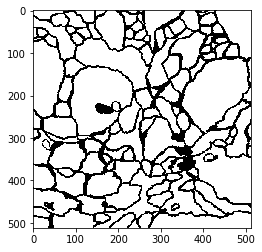

In [120]:
plt.imshow(gt*255)

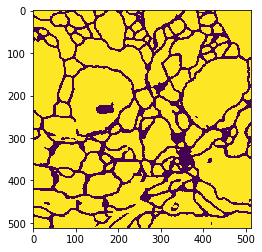

In [121]:
plt.imshow(pred)

In [137]:
class_type = 0
join = np.logical_and(gt[:, :, 0] == class_type, pred == class_type)
union = np.logical_or(gt[:, :, 0] == class_type, pred == class_type)
print('IOU for membrane is {}'.format(np.sum(join) / np.sum(union)))

IOU for membrane is 0.7199890027203797


In [138]:
class_type = 1
join = np.logical_and(gt[:, :, 0] == class_type, pred == class_type)
union = np.logical_or(gt[:, :, 0] == class_type, pred == class_type)
print('IOU for background is {}'.format(np.sum(join) / np.sum(union)))

IOU for background is 0.9088880204532293


### Plot raw data, ground truth and predictions

NOTE: Table PREDICTIONS contains compressed images.


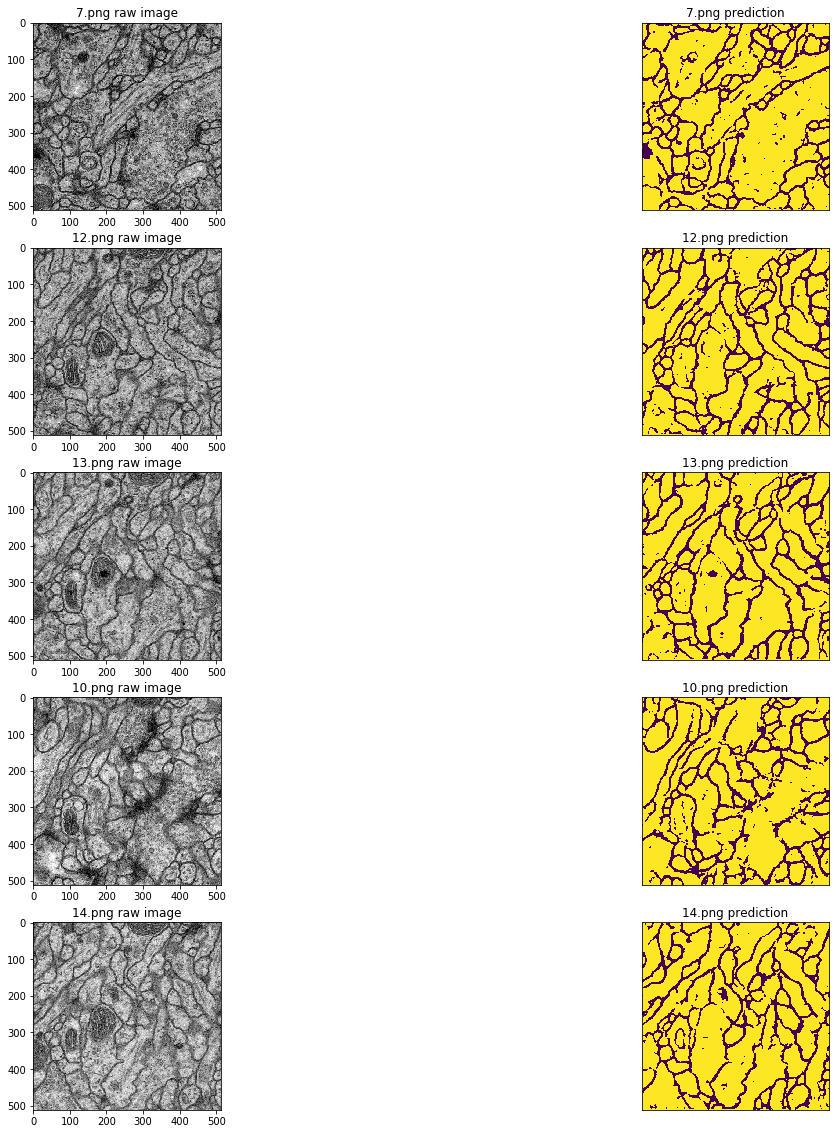

In [94]:
table = 'predictions'
contain_label = 'labels' in s.CASTable(table).columns
fetch_img_vars = ['_image_', '_filename_0'] + (['labels'] if contain_label else [])
test_imgs = s.fetchImages(table={'name': table}, to=30,
                          fetchImagesVars=fetch_img_vars).Images

fig = plt.figure(figsize = (20,20))
k = 1
image_index = range(5)
n_row = len(image_index)
contain_label = 'labels' in test_imgs.columns
n_col = 3 if contain_label else 2
for i in image_index:
    filename = test_imgs.loc[i,'_filename_0']
    
    test_img = test_imgs.loc[i, 'Image']
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(test_img)
    k = k + 1
    plt.title(filename + ' raw image')
    
    if contain_label:
        gt_img = test_imgs.loc[i, 'labels']
        gt_img = np.array(gt_img) * 255
        ax = fig.add_subplot(n_row, n_col, k)
        plt.imshow(gt_img)
        k = k + 1
        plt.title(filename + ' ground truth')
    
    p_idx = prediction_order.index(filename)
    prediction = pred_array_reshape[p_idx] * 255
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(prediction)
    k = k + 1
    
    plt.title(filename + ' prediction')
    
    plt.xticks([]), plt.yticks([])

In [84]:
sw.options.cas.dataset.max_rows_fetched = 1000000

In [85]:
weights = s.CASTable('seg_weights', where='_LayerID_ = 31.0')

In [86]:
weights.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,_LayerID_,31.000000,31.000000,1154.0,0.0,31.000000,35774.000000,0.000000,0.000000,0.000000,1.108994e+06,0.000000e+00,0.000000,NaN,NaN,NaN,NaN
1,_WeightID_,0.000000,1153.000000,1154.0,0.0,576.500000,665281.000000,333.275412,9.810708,111072.500000,5.116011e+08,1.280666e+08,57.810132,58.762321,0.000000,0.000000,-1.200000
2,_Weight_,-0.102935,0.121648,1154.0,0.0,0.002585,2.982964,0.042744,0.001258,0.001827,2.114280e+00,2.106569e+00,1653.602151,2.054338,0.040168,-0.033371,-1.082908


C:\TEMP\python\swat\cas\table.py:6538: RuntimeWarning: Data downloads are limited to 1000000 rows.  To change this limit, set swat.options.cas.dataset.max_rows_fetched to the desired limit.
  % max_rows_fetched, RuntimeWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021516DAED30>]],
      dtype=object)

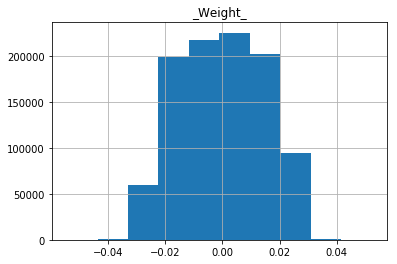

In [87]:
weights = s.CASTable('seg_weights', where='_LayerID_ = 19.0')
weights.hist(column='_Weight_')

In [6]:
s.endsession()

+ Elapsed: 9.8e-05s, user: 6.5e-05s, sys: 2.6e-05s, mem: 0.194mb